# Time-Continuous Density Estimation

This tutorial aims to guide you through the process of Time-Continuous Density Estimation using Mellon.
The density estimate helps in understanding how the probability of a specific cell state
existing in the tissue varies over time.

Let's start by importing the necessary modules:

In [1]:
import numpy as np
import pandas as pd

import mellon
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt

Here's how you can set up your notebook to display matplotlib graphics and configure some aesthetic parameters.

In [2]:
# This line enables the interactive display of figures in Jupyter notebook.
%matplotlib inline

# Customize matplotlib settings
matplotlib.rcParams["figure.dpi"] = 100  # Adjusts the resolution of the figure.
matplotlib.rcParams["image.cmap"] = "Spectral_r"  # Sets the default colormap.
matplotlib.rcParams["figure.figsize"] = [6, 6]  # Defines the default figure size.

# Disabling the axes for a more minimalistic plot look:
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.right"] = False

## Step 1: Reading and Displaying the Dataset

Initially, we will load the RNA AnnData file from a provided URL, saving it to a local disk for further analysis. If you prefer to store this file at a different location, modify the rna_annData_file path accordingly. The dataset contains preprocessed information pertaining to the mouse gastrulation atlas from [Pijuan-Sala, B., Griffiths, J.A., Guibentif, C. et al. A single-cell molecular map of mouse gastrulation and early organogenesis. *Nature* **566**, 490–495 (2019)](https://doi.org/10.1038/s41586-019-0933-9).

Note: The dataset with all the processed data is ~20G.

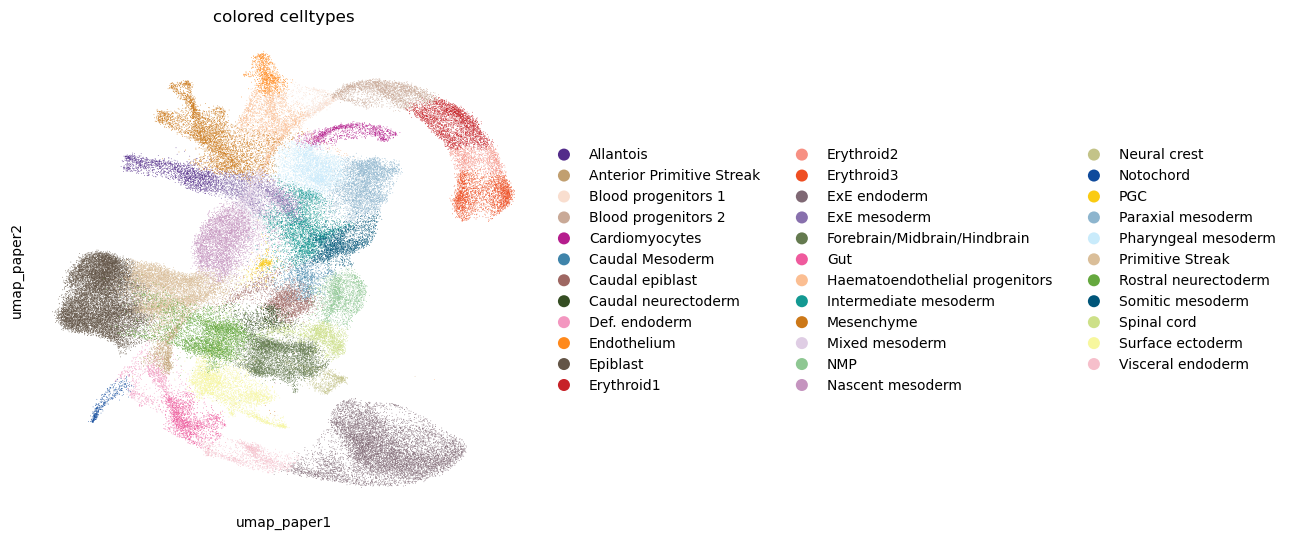

In [3]:
url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_mouse-gastrulation-atlas.h5ad"
annData_file = "data/preprocessed_mouse-gastrulation-atlas.h5ad"
ad = sc.read(annData_file, backup_url=url)
sc.pl.scatter(ad, basis="umap_paper", color="colored_celltypes")

In [4]:
ad

AnnData object with n_obs × n_vars = 98192 × 16695
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'TP_density', 'custom_exclude', 'exclude_mask', 'exclude', 'colored_celltypes', 'palantir_pseudotime', 'palantir_entropy'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'DM_EigenValues', 'celltype_colors', 'colored_celltypes_colors', 'exclude_colors', 'hvg', 'neighbors', 'palantir_waypoints', 'pca', 'stage_colors', 'umap'
    obsm: 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_pca', 'X_umap', 'X_umap_paper', 'branch_masks', 'palantir_fate_probabilities'
    varm: 'PCs'
    layers: 'MAGIC_imputed_data

## Step 2: Numerical Representation of Time

The time at which the samples were taken must be present as a numerical value. This will help us assess the similarity of different samples based on their time of collection.

In [5]:
stage_to_numerical = {
    "E6.5": 6.5,
    "E6.75": 6.75,
    "E7.0": 7.0,
    "E7.25": 7.25,
    "E7.5": 7.5,
    "E7.75": 7.75,
    "E8.0": 8.0,
    "E8.25": 8.25,
    "E8.5": 8.5,
}
numerical_to_stage = {n: s for s, n in stage_to_numerical.items()}

ad.obs["stage_numerical"] = pd.Series(
    ad.obs["stage"].map(stage_to_numerical), dtype=float
)

sampled_times = ad.obs[["stage", "stage_numerical"]].drop_duplicates(ignore_index=True)
sampled_times

,stage,stage_numerical
0,E6.5,6.50
1,E7.5,7.50
2,E6.75,6.75
3,E7.75,7.75
4,E7.0,7.00
5,E8.0,8.00
6,E8.5,8.50
7,E7.25,7.25
8,E8.25,8.25


## Step 3: Time-Continuous Density Estimation

In this step, we utilize the [Time-Sensitive Density Estimator](https://mellon.readthedocs.io/en/latest/model.html#mellon.model.TimeSensitiveDensityEstimator) to examine the evolution of densities within our dataset over time.

We set the intrinsic dimensionality to 2. This parameter setting doesn't significantly affect the final density ranking, but it plays a role in facilitating the conversion from log-density to linear density later in our analysis.

The time length scale `ls_time` is set using a heuristic defined as $1.5\cdot\Delta_t=0.375$, where $\Delta_t$ represents the distance between consecutive time steps. This parameter adjusts the smoothness of the density over time, and our heuristic choice ensures a smooth interpolation between the available samples.

If you prefer a more data-driven approach, albeit computationally intensive, you can either leave the `ls_time` parameter unspecified or set it to `None`. In this case Mellon will compute and compare the density for each time point individually, thus inferring the rate of change in similarity over time.

In [6]:
%%time
X = ad.obsm["DM_EigenVectors"]
X_times = ad.obs["stage_numerical"]

# this code is here to prevent accidental usage of default values on new data
ls_time_estimate = 1.5 * np.mean(np.diff(np.sort(X_times.unique())))
if 0.37 > ls_time_estimate or ls_time_estimate > 0.38:
    raise ValueError(
        "You time increments are very different from the tutorial data. "
        "Please choose amn appropriate time span or pass ls_time=None (takes long)."
    )

# Initialize the time-sensitive density estimator with an intrinsic dimensionality of 2
t_est = mellon.TimeSensitiveDensityEstimator(d=2, ls_time=0.375)

# Fit the estimator to the data
t_est.fit(X, X_times)

# Save the predictor for later density evaluations
density_predictor = t_est.predict

[2024-05-20 14:39:22,653] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (98,192) and rank = 1.0.
[2024-05-20 14:39:22,654] [INFO    ] Computing nearest neighbor distances within time points.
[2024-05-20 14:39:33,877] [INFO    ] Using covariance function (Matern52(active_dims=slice(None, -1, None), ls=0.0028995675014713263) * Matern52(active_dims=-1, ls=0.375)).
[2024-05-20 14:39:34,055] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-05-20 14:40:35,523] [INFO    ] Estimating approximation accuracy since 98,192 samples are more than 10 x 5,000 landmarks.
[2024-05-20 14:40:47,426] [WARNING ] High approx. rank fraction (91.4%). Consider increasing 'n_landmarks'.
[2024-05-20 14:40:47,431] [INFO    ] Using rank 5,000 covariance representation.
[2024-05-20 14:40:52,939] [INFO    ] Running inference using L-BFGS-B.
[2024-05-20 14:43:21,518] [INFO    ] Computing predictive function.
CPU times: user 28min 3s, sys: 2min 56s, total: 31min
Wall 

## Step 4: Density Evaluation and Plotting

The `density_predictor` is a subclass of the
[mellon.base_predictor.PredictorTime](https://mellon.readthedocs.io/en/latest/predictor.html#mellon.base_predictor.PredictorTime).
Thus the cell-state density can be evaluated for any time point. For instance, we can evaluate the
density for all cell states at stage E7.10 wich is notably not covered by a sample.

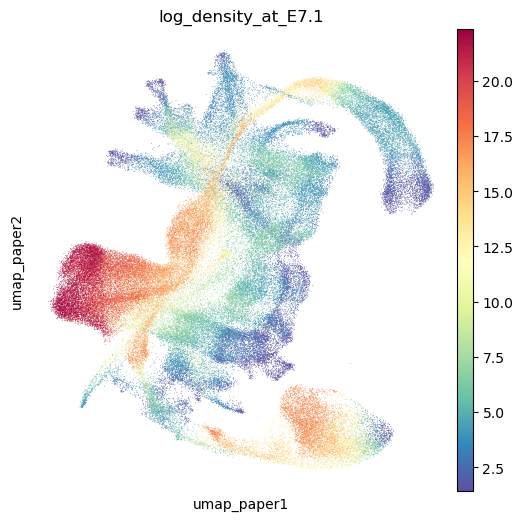

CPU times: user 34 s, sys: 1min 19s, total: 1min 53s
Wall time: 26.4 s


In [7]:
%%time
time = 7.10
ad.obs[f"log_density_at_E{time}"] = density_predictor(X, time)

sc.pl.embedding(ad, basis="umap_paper", color=f"log_density_at_E{time}")

Similarly, we can compute the rate of density change for any time point and cell state.

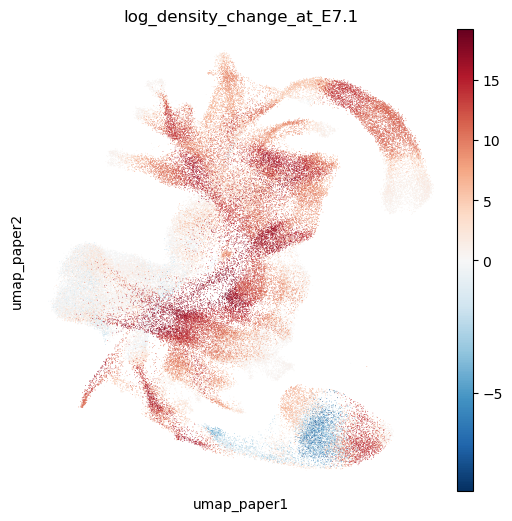

CPU times: user 28.4 s, sys: 17.3 s, total: 45.7 s
Wall time: 8.68 s


In [8]:
%%time
ad.obs[f"log_density_change_at_E{time}"] = density_predictor.time_derivative(X, time)

sc.pl.embedding(
    ad,
    basis="umap_paper",
    color=f"log_density_change_at_E{time}",
    color_map="RdBu_r",
    vcenter=0,
)

## Step 5: Generating a Continuous Trajectory

We can use mellon's
[FunctionEstimator](https://mellon.readthedocs.io/en/latest/model.html#mellon.model.FunctionEstimator)
to determine a continuous differentiation trajectory through the selected cell-state space.
For illustration, we will start by finding a continuous trajectory through the UMAP state representation of cells.

In [9]:
%%time
idx = ad.obsm["branch_masks"]["Erythroid3"]
pseudotime = ad.obs.loc[idx, "palantir_pseudotime"].values
pseudotime_grid = np.linspace(np.min(pseudotime), np.max(pseudotime), 200)

umap_est = mellon.FunctionEstimator(ls=1, sigma=5, n_landmarks=10)
umap_trajectory = umap_est.fit_predict(
    pseudotime, ad.obsm["X_umap"][idx, :], pseudotime_grid
)

[2024-05-20 14:43:56,854] [INFO    ] Using sparse Gaussian Process since n_landmarks (10) < n_samples (33,237) and rank = 1.0.
[2024-05-20 14:43:56,855] [INFO    ] Using covariance function Matern52(ls=1.0).
[2024-05-20 14:43:56,880] [INFO    ] Computing 10 landmarks with k-means clustering.
CPU times: user 13.3 s, sys: 418 ms, total: 13.7 s
Wall time: 1.37 s


This trajectory can be visualized using matplotlib.

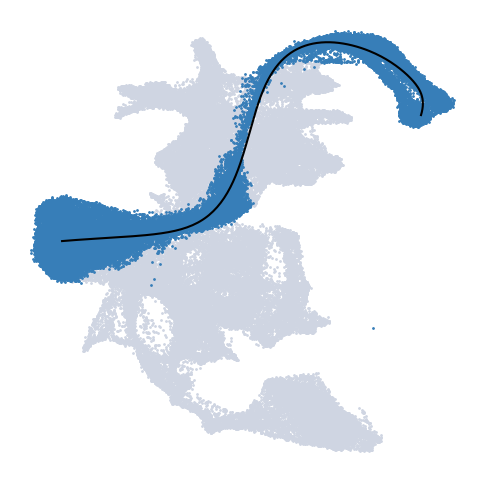

In [10]:
fig, ax = plt.subplots(1, 1)
ax.scatter(ad.obsm["X_umap"][~idx, 0], ad.obsm["X_umap"][~idx, 1], c="#CFD5E2", s=1)
ax.scatter(ad.obsm["X_umap"][idx, 0], ad.obsm["X_umap"][idx, 1], c="#377EB8", s=1)
ax.plot(umap_trajectory[:, 0], umap_trajectory[:, 1], color="black")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Generating a Trajectory in State Space

Similar to how we created a trajectory through the UMAP state representation,
we are now going to create a trajectory within the more complex, higher-dimensional
space of the diffusion map of the cells. However, given the high-dimensionality of
this space, we will not attempt to provide a comprehensive visualization.
Additionally, to address the reduced variability observed within the diffusion
components, we modulate the `sigma` parameter to 0.1.

In [11]:
%%time
diffcomp_est = mellon.FunctionEstimator(ls=1, sigma=0.1, n_landmarks=100)
diffcomp_trajectory = diffcomp_est.fit_predict(
    pseudotime, ad.obsm["DM_EigenVectors"][idx, :], pseudotime_grid
)

[2024-05-20 14:43:58,532] [INFO    ] Using sparse Gaussian Process since n_landmarks (100) < n_samples (33,237) and rank = 1.0.
[2024-05-20 14:43:58,533] [INFO    ] Using covariance function Matern52(ls=1.0).
[2024-05-20 14:43:58,534] [INFO    ] Computing 100 landmarks with k-means clustering.
CPU times: user 16.1 s, sys: 629 ms, total: 16.7 s
Wall time: 1.71 s


## Step 6: Evaluating Density Along the Trajectory Over Time and Visualization

We can evaluate the density predictor along the trajectory represented by `diffcomp_trajectory` across various time points denoted by `time_grid_raw` using the `multi_time` parameter. 


In [12]:
%%time
time_grid_raw = np.linspace(
    X_times.astype(float).min(), X_times.astype(float).max(), 200
)
densities = density_predictor(diffcomp_trajectory, multi_time=time_grid_raw)

CPU times: user 13.4 s, sys: 31.2 s, total: 44.6 s
Wall time: 10.6 s


To illustrate temporal changes in density along the trajectory, a 2D density map can be produced using `pyplot.matshow`. Grey vertical lines are added to denote the specific time points when the samples were collected.

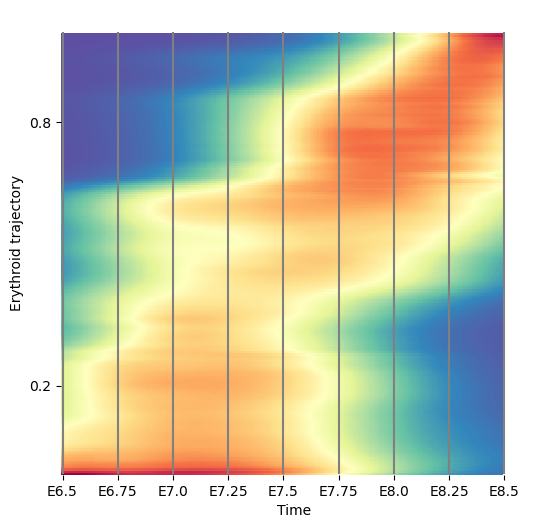

In [13]:
aspect = densities.shape[1] / densities.shape[0]
plt.matshow(densities, origin="lower", aspect=aspect)


# Function to convert time to corresponding matrix position
def time_to_matrix_position(times):
    return (
        len(time_grid_raw) * (times - np.min(times)) / (np.max(times) - np.min(times))
    )


plt.xlabel("Time")
plt.ylabel("Erythroid trajectory")
num_time = sampled_times["stage_numerical"].astype(float).values
plt.xticks(time_to_matrix_position(num_time), sampled_times["stage"])
plt.vlines(time_to_matrix_position(num_time), 0, len(pseudotime_grid), color="grey")
plt.gca().xaxis.tick_bottom()
plt.yticks(
    np.quantile(np.arange(len(pseudotime_grid)), np.array([0.2, 0.8])),
    np.array([0.2, 0.8]),
)

plt.show()

In this section, we generate a trajectory in the state space, which offers a more nuanced view of the cell states. The density predictor is evaluated along this trajectory for multiple time points. Subsequently, we visualize the resulting 2D density map to observe how cell-state densities vary along the trajectory and across different time points.

## Step 7: Saving the Predictor

The density predictor can be serialized and saved for future use.
It can be stored in the AnnData `uns` attribute, and the AnnData can be saved with the `write` method.
The predictor can be reconstructed using the
[from_dict](https://mellon.readthedocs.io/en/latest/predictor.html#mellon.Predictor.from_dict)
method of [mellon.Predictor](https://mellon.readthedocs.io/en/latest/predictor.html#mellon.Predictor).

In [14]:
ad.uns["density_predictor"] = density_predictor.to_dict()

To save the AnnData:

In [15]:
ad.write("data/preprocessed_mouse-gastrulation-atlas_with_density_predictor.h5ad")

To reconstruct the predictor:

In [16]:
density_predictor = mellon.Predictor.from_dict(ad.uns["density_predictor"])

By the end of this tutorial, you should have a basic understanding of time-continuous density estimation with Mellon.
This knowledge can be valuable in many areas of single-cell analysis of developmental and regenerative tissue,
where understanding the dynamics of cell states over time is crucial.